In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [2]:
train_ds= load_dataset('Dataset_Draft')

Resolving data files:   0%|          | 0/124473 [00:00<?, ?it/s]

In [3]:
train_ds = train_ds["train"].train_test_split(test_size=0.2) 
train_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 99578
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 24895
    })
})

In [4]:
train_ds["train"].column_names

['image', 'label']

In [5]:
labels = train_ds["train"].features["label"]
labels.num_classes

447

In [6]:
labels.int2str(train_ds["train"][536]["label"])

'Nasturtium officinale'

In [7]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]
    
    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(train_ds["train"].features["label"].int2str(labels[i]))
    
    plt.show()

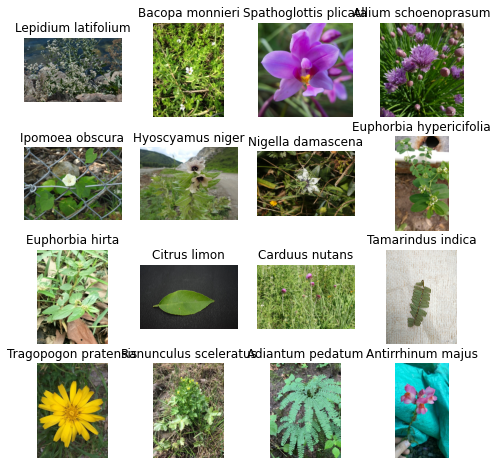

In [8]:
show_image_grid(train_ds, "train")

### Training

In [9]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = train_ds.with_transform(transform)

In [10]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [11]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [12]:
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm

labels = train_ds["train"].features["label"].names

model_name = "google/vit-base-patch16-384"

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)


/home/moose/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/home/moose/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/home/moose/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attenti

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit_base_384", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=8, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=4000,                # number of update steps before saving checkpoint
  eval_steps=4000,                # number of update steps before evaluating
  logging_steps=4000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices


In [14]:
from transformers import Trainer

image_processor = ViTImageProcessor.from_pretrained(model_name)

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

loading configuration file preprocessor_config.json from cache at /home/moose/.cache/huggingface/hub/models--google--vit-base-patch16-384/snapshots/2960116e809e2fca84146dbb240289aee7db4827/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 384. Converted to {'height': 384, 'width': 384}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}



In [15]:
trainer.train()

***** Running training *****
  Num examples = 99,578
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 124,480
  Number of trainable parameters = 86,434,239


Step,Training Loss,Validation Loss,Accuracy,F1
4000,1.933600,0.668508,0.856999,0.847253
8000,0.570700,0.473616,0.885640,0.883155
12000,0.466400,0.438901,0.893673,0.892840
16000,0.226600,0.429432,0.897168,0.897453
20000,0.220900,0.430166,0.899498,0.899387
24000,0.217500,0.408735,0.906929,0.906618
28000,0.114700,0.425737,0.907170,0.908046


***** Running Evaluation *****
  Num examples = 24895
  Batch size = 8
Saving model checkpoint to ./vit_base_384/checkpoint-4000
Configuration saved in ./vit_base_384/checkpoint-4000/config.json
Model weights saved in ./vit_base_384/checkpoint-4000/pytorch_model.bin
Image processor saved in ./vit_base_384/checkpoint-4000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 24895
  Batch size = 8
Saving model checkpoint to ./vit_base_384/checkpoint-8000
Configuration saved in ./vit_base_384/checkpoint-8000/config.json
Model weights saved in ./vit_base_384/checkpoint-8000/pytorch_model.bin
Image processor saved in ./vit_base_384/checkpoint-8000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 24895
  Batch size = 8
Saving model checkpoint to ./vit_base_384/checkpoint-12000
Configuration saved in ./vit_base_384/checkpoint-12000/config.json
Model weights saved in ./vit_base_384/checkpoint-12000/pytorch_model.bin
Image processor saved in ./vit_bas

KeyboardInterrupt: 

In [ ]:
trainer.evaluate(dataset["test"])

### Checkpoint 

In [17]:
best_checkpoint = 24000

model_loaded = ViTForImageClassification.from_pretrained(f"./vit_base_384/checkpoint-{best_checkpoint}").to("cuda")

loading configuration file ./vit_base_384/checkpoint-24000/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-384",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Abrus precatorius",
    "1": "Abutilon theophrasti",
    "2": "Acacia dealbata",
    "3": "Acacia pycnantha",
    "4": "Achillea millefolium",
    "5": "Aconitum napellus",
    "6": "Acorus calamus",
    "7": "Actaea racemosa",
    "8": "Actaea spicata",
    "9": "Adansonia digitata",
    "10": "Adiantum capillus-veneris",
    "11": "Adiantum pedatum",
    "12": "Agave americana",
    "13": "Ageratum houstonianum",
    "14": "Albizia julibrissin",
    "15": "Alcea rosea",
    "16": "Allium cepa",
    "17": "Allium schoenoprasum",
    "18": "Alocasia odora",
    "19": "Aloe ferox",
    "20": "Aloe vera",
    "21": "Alpinia z

In [18]:
import os

def load_image(image_path):
    if os.path.exists(image_path):
        return Image.open(image_path)

def get_prediction(model, url_or_path):
  # load the image
  img = load_image(url_or_path)
  # preprocessing the image
  pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to("cuda")
  # perform inference
  output = model(pixel_values)
  print(output.logits.softmax(dim=1).max().item())
  print(output.logits.softmax(dim=1).argmax().item())
  # get the label id and return the class name
  return model.config.id2label[int(output.logits.softmax(dim=1).argmax())]



In [19]:
get_prediction(model_loaded,"magnifera.jpeg")

0.5295178294181824
107


'Coffee'

In [22]:
get_prediction(model_loaded,"tulsi.jpeg")

0.564015805721283
295


'Ocimum tenuiflorum'

In [24]:
get_prediction(model_loaded,"tulsi_2.jpeg")

0.9994322657585144
295


'Ocimum tenuiflorum'

In [26]:
torch.save(model_loaded.state_dict(), "vit_base_384/saved_model/model.pt")

In [27]:
labels

['Abrus precatorius',
 'Abutilon theophrasti',
 'Acacia dealbata',
 'Acacia pycnantha',
 'Achillea millefolium',
 'Aconitum napellus',
 'Acorus calamus',
 'Actaea racemosa',
 'Actaea spicata',
 'Adansonia digitata',
 'Adiantum capillus-veneris',
 'Adiantum pedatum',
 'Agave americana',
 'Ageratum houstonianum',
 'Albizia julibrissin',
 'Alcea rosea',
 'Allium cepa',
 'Allium schoenoprasum',
 'Alocasia odora',
 'Aloe ferox',
 'Aloe vera',
 'Alpinia zerumbet',
 'Alternanthera philoxeroides',
 'Amorpha fruticosa',
 'Andrographis paniculata',
 'Angelica archangelica',
 'Annona squamosa',
 'Anthemis cotula',
 'Antirrhinum majus',
 'Aquilegia vulgaris',
 'Arabidopsis thaliana',
 'Arbutus unedo',
 'Arctium lappa',
 'Argemone mexicana',
 'Arisaema triphyllum',
 'Arnica montana',
 'Artemisia absinthium',
 'Artocarpus heterophyllus',
 'Arundina graminifolia',
 'Arundo donax',
 'Asarum europaeum',
 'Asclepias curassavica',
 'Asphodelus fistulosus',
 'Asplenium ceterach',
 'Asplenium nidus',
 'Asp